In [1]:
##1
## Importing Modules

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm #just to get the progress bar 
import random
warnings.filterwarnings('ignore')

%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D ,Dropout, Flatten, MaxPooling2D, Input


In [2]:
##2 (CHANGER LA DIRECTORY)
## Load Dataset

BASE_DIR=r"C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset"

In [3]:
##3
#labels: race, gender, ethnicity


image_paths=[]
age_labels=[]
gender_labels=[]


for filename in tqdm(os.listdir(BASE_DIR)): #iterates in all the files inside the direcetory
    image_path=os.path.join(BASE_DIR,filename)
    temp=filename.split('_') #on split le nom de l'image selon les _ pour avoir age , date etc..
    if len(temp) >= 3 and all(p.isdigit() for p in temp[:3]):
        age =int(temp[0])#premier element de la liste
        gender =int(temp[1])#second element de la liste
        image_paths.append(image_path)
        age_labels.append(age)
        gender_labels.append(gender)
    else:
        print(f"Skipping file with unexpected format: {filename}")
    #la barre en bas montre que we loaded all the images 
    

  0%|          | 0/24108 [00:00<?, ?it/s]

Skipping file with unexpected format: 39_1_20170116174525125.jpg
Skipping file with unexpected format: 53__0_20170116184028385.jpg
Skipping file with unexpected format: 61_1_20170109142408075.jpg
Skipping file with unexpected format: 61_3_20170109150557335.jpg


In [4]:
##4
#convert my images into a data frame
df=pd.DataFrame()
df['image_path'],df['age'],df['gender']=image_paths, age_labels, gender_labels # ce sont les colonnes de mon dataframe
df.sample(10) #cette commande nous permet de voir 10 lignes aléatoire, on a creer a proper dataframe


image_path  age  gender
18528  C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset...   50       1
8016   C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset...   26       1
19253  C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset...   54       0
19114  C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset...   53       1
7631   C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset...   26       1
20815  C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset...   60       0
17010  C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset...   45       0
13730  C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset...   35       1
6330   C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset...   26       0
6068   C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset...   26       0

In [5]:
##5
#define labels of gender
gender_dict={0:'Male',1:'Female'}

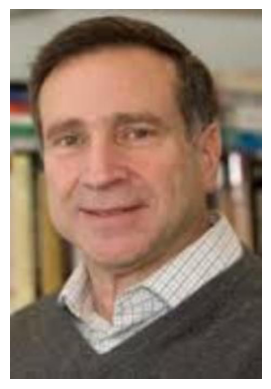

In [6]:
##6
# Exploratory Data Analysis
from PIL import Image  # PIL est un module utilise pour loader des images 
img= Image.open(df['image_path'][random.randint(0, len(df) - 1)]) #on ouvre juste une image aléatoire
plt.axis('off')
plt.imshow(img);
#for better image preproceessing et ne pas surcharge la RAM, La RAM EST LIMITE on utilise grayscale et on la reesize

In [7]:
##10
## Extracting features
from tensorflow.keras.preprocessing.image import load_img

def extract_features(images):
    features=[]
    for image in tqdm (images):
         #on ne peux pas  se permettre de load toutes les images en RGB: 3 dimensions  et prendre toute la memoire
        img = load_img(image)
        #img = load_img(image, color_mode='grayscale')
        img=img.resize((128,128),Image.ANTIALIAS)
        img=np.array(img)
        features.append(img)
        
    #we convert the features to a numpy array
    features=np.array(features) # cette etape est obligatoire car les neurals network gere que les array 
    features=features.reshape(len(features),128,128,3) #ca prend en arguments number fo features, width, height et la dimension
    # dans notre cas grayscale image ducoup dimension=1
    #dans le cas ou on sera rester en RGB, on oublie ceci 
    return features 
    
        

In [8]:
##11
X=extract_features(df['image_path'])

  0%|          | 0/24104 [00:00<?, ?it/s]

In [9]:
##12
X.shape
#on verifie bien que la dernier valeur est 1 cad il est en graycale

(24104, 128, 128, 3)

In [10]:
##13
#normalize the images 
X=X/255.0 #la valeur dee la pixel est de 0-255 maintenant  elle sera de la range 0 to 1 

In [11]:
##14
y_gender=np.array(df['gender']) #on convertit to numpy
y_age=np.array(df['age']) #on convertir to numpy 

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

# Définir la taille des batchs
batch_size = 32
valid_batch_size = 32

# Définir la forme d'entrée (exemple)
input_shape = (128, 128, 3)

# Définir le modèle séquentiel
model_age = Sequential()

# Ajouter les couches convolutionnelles et de pooling
model_age.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model_age.add(MaxPooling2D(pool_size=(2, 2)))

model_age.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_age.add(MaxPooling2D(pool_size=(2, 2)))

# Ajouter une couche Flatten pour aplatir les données
model_age.add(Flatten())

# Ajouter les couches entièrement connectées avec Dropout
model_age.add(Dense(128, activation='relu'))
model_age.add(Dropout(0.3))

# Ajouter la couche de sortie pour la prédiction de l'âge
model_age.add(Dense(1, activation='linear'))  # Utiliser 'linear' pour une sortie de régression

# Compiler le modèle
model_age.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

# Définir le callback pour sauvegarder le modèle complet
checkpoint_callback = ModelCheckpoint(
    filepath='AgePersonelModel.keras',
    monitor='val_mae',
    save_best_only=True,
    save_weights_only=False,
    mode='min',  # 'min' car nous voulons minimiser 'val_mae'
    verbose=1
)

# Entraîner le modèle
history = model_age.fit(
    x=X, 
    y=y_age, 
    epochs=50, 
    batch_size=batch_size, 
    validation_split=0.2, 
    callbacks=[checkpoint_callback]
)




Epoch 1/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 220.9840 - mae: 11.4738
Epoch 1: val_mae improved from inf to 34.15331, saving model to AgePersonelModel.keras
603/603 ━━━━━━━━━━━━━━━━━━━━ 178s 281ms/step - loss: 220.9235 - mae: 11.4722 - val_loss: 1375.4563 - val_mae: 34.1533
Epoch 2/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 158.3382 - mae: 9.7010
Epoch 2: val_mae improved from 34.15331 to 33.90728, saving model to AgePersonelModel.keras
603/603 ━━━━━━━━━━━━━━━━━━━━ 161s 268ms/step - loss: 158.3349 - mae: 9.7009 - val_loss: 1374.8130 - val_mae: 33.9073
Epoch 3/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 140.3229 - mae: 9.2068
Epoch 3: val_mae improved from 33.90728 to 32.18652, saving model to AgePersonelModel.keras
603/603 ━━━━━━━━━━━━━━━━━━━━ 152s 252ms/step - loss: 140.3259 - mae: 9.2069 - val_loss: 1213.1670 - val_mae: 32.1865
Epoch 4/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 129.0151 - mae: 8.7628
Epoch 4: val_mae did not improve fro

KeyboardInterrupt: 

NameError: name 'history' is not defined

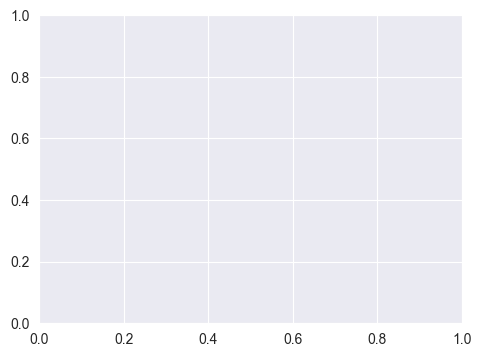

In [13]:
# Plotting the training history for loss and MAE
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# MAE plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

In [14]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Charger le modèle sauvegardé
model = load_model('AgePersonelModel.keras') 

# Préparer les nouvelles données pour la prédiction

# IL FAUT RUN LES CODES AU DEBUT JUSQU'AU NUMERO 10
random_image_paths = df['image_path'].sample(n=25, random_state=42).tolist()

# Remplacez ceci par vos propres données à prédire
X_new = extract_features(random_image_paths)  # Par exemple, un NumPy array avec les mêmes dimensions que les données d'entraînement

# Faire des prédictions
predictions = model.predict(X_new)

# Afficher les résultats
print(predictions)


  0%|          | 0/25 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
[[-815.1217 ]
 [2139.7034 ]
 [ 528.5198 ]
 [ 387.28842]
 [ 144.21648]
 [1925.1848 ]
 [1712.4115 ]
 [2255.1587 ]
 [2580.642  ]
 [-529.3346 ]
 [1902.4517 ]
 [-630.0004 ]
 [1959.2235 ]
 [1316.9558 ]
 [1674.9801 ]
 [1200.9589 ]
 [3385.2527 ]
 [2333.4988 ]
 [3112.4543 ]
 [-262.81546]
 [2104.9202 ]
 [ 654.955  ]
 [1145.7488 ]
 [ 318.845  ]
 [2859.593  ]]


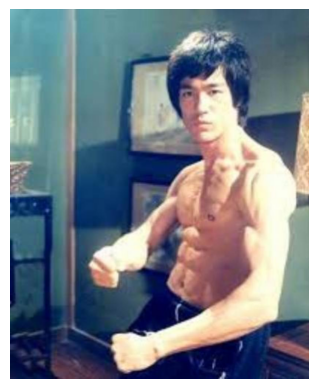

C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset\26_0_2_20170116182240440.jpg


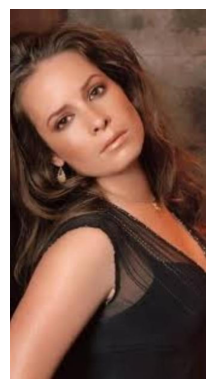

C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset\30_1_0_20170117171117386.jpg


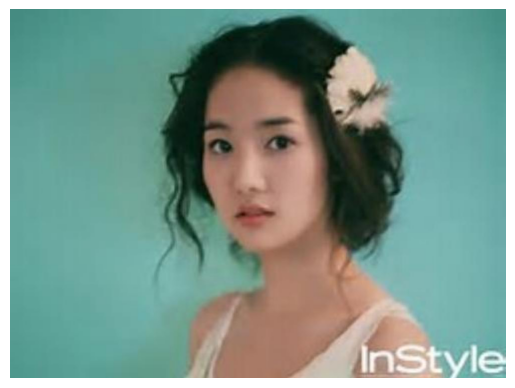

C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset\22_1_2_20170116172549492.jpg


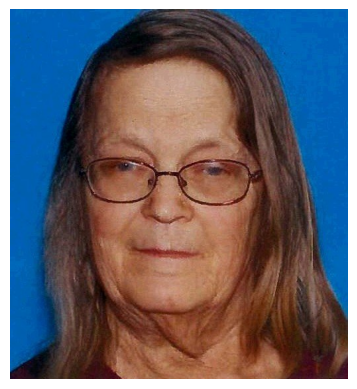

C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset\76_1_0_20170110181611591.jpg


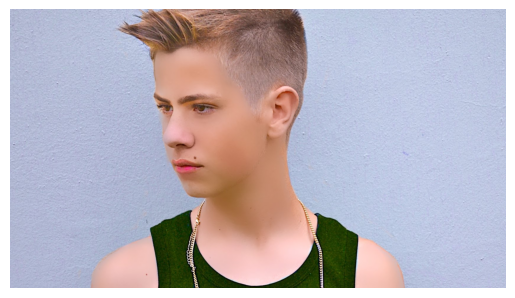

C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset\11_0_0_20170110220657089.jpg


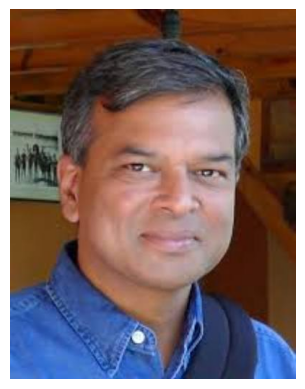

C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset\36_0_3_20170119201833789.jpg


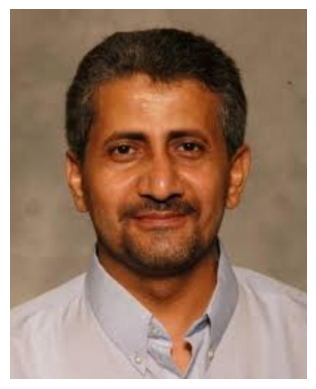

C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset\46_0_4_20170104183938014.jpg


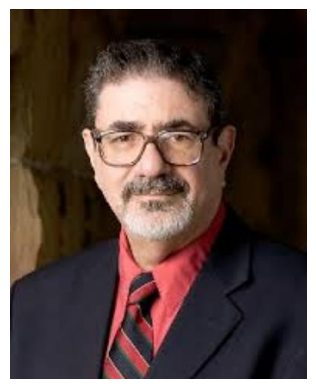

C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset\57_0_0_20170104212832053.jpg


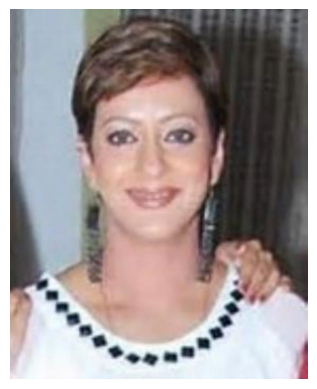

C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset\45_1_0_20170117175418025.jpg


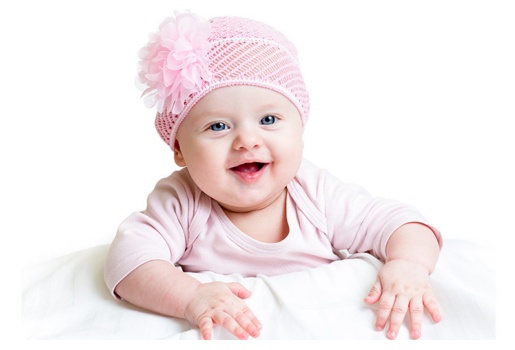

C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset\1_1_0_20170109193018259.jpg


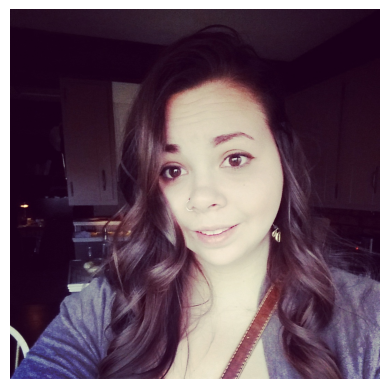

C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset\20_1_0_20170109214125992.jpg


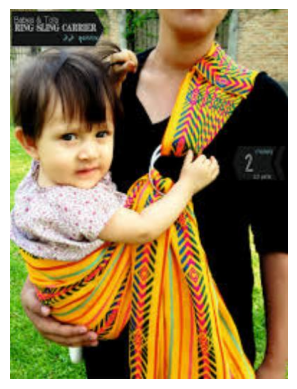

C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset\1_1_4_20161221201729160.jpg


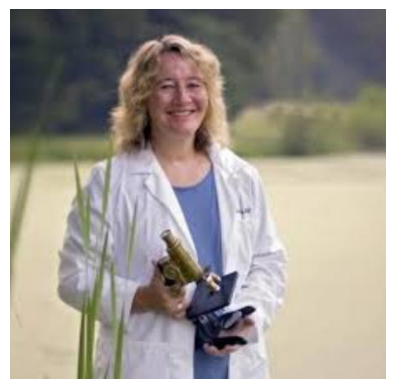

C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset\45_1_0_20170109132846228.jpg


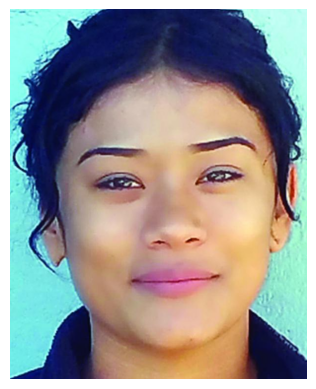

C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset\21_1_2_20170103201741359.jpg


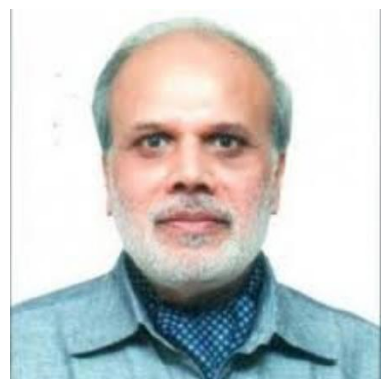

C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset\57_0_3_20170119201739436.jpg


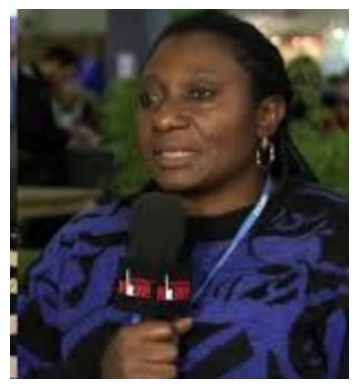

C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset\55_1_1_20170112213225871.jpg


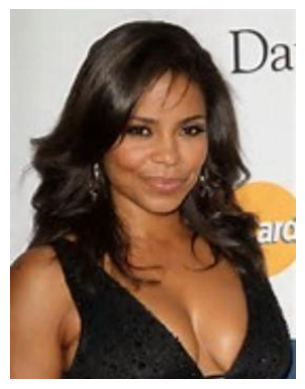

C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset\42_1_1_20170113001932011.jpg


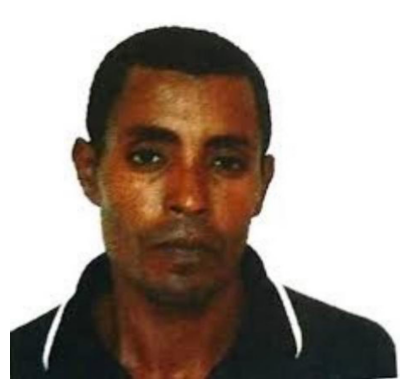

C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset\35_0_1_20170117094513411.jpg


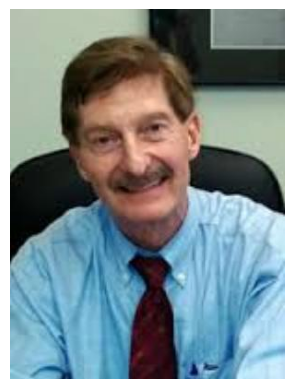

C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset\54_0_0_20170104184603397.jpg


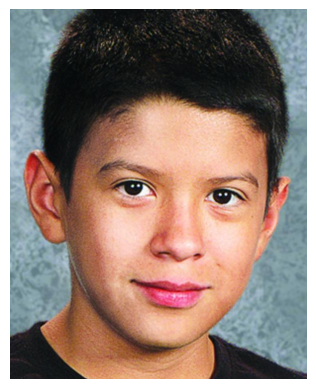

C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset\15_0_0_20170103201316167.jpg


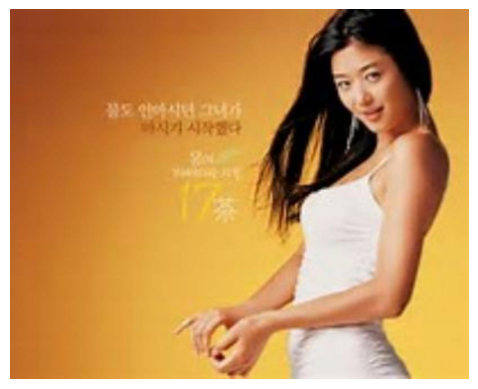

C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset\26_1_2_20170116175437182.jpg


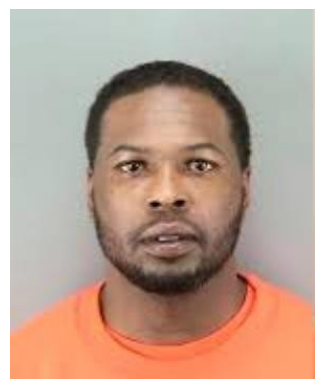

C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset\34_0_4_20170117105033191.jpg


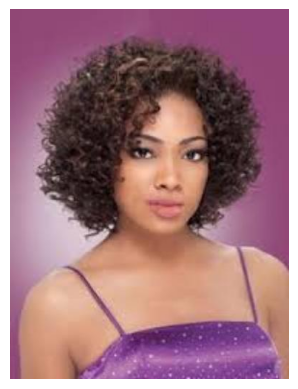

C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset\22_1_1_20170105002015683.jpg


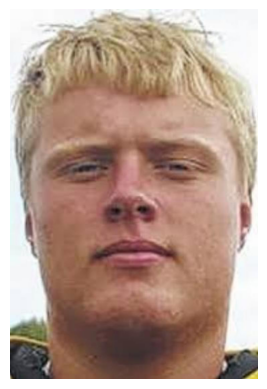

C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset\27_0_0_20170116205604495.jpg


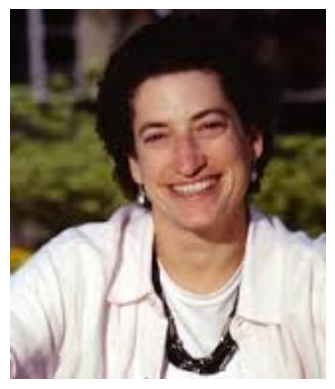

C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset\40_1_0_20170105164619947.jpg


In [15]:
from PIL import Image

for img_path in random_image_paths:
    img = Image.open(img_path)
    plt.figure()
    plt.axis('off')
    plt.imshow(img)
    plt.show()
    print(img_path)
